In [2]:
%matplotlib  inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from franke import FrankeFunction, FrankePlot
from mpl_toolkits.mplot3d import Axes3D
import tools
import plotting

In [4]:
seed = 12345
x,y,z,noise = tools.generate_data(N = 1000, seed = seed)
deg = 5

from tools import get_X_poly2D, fit_poly2D
regr = fit_poly2D(x, y, z, deg = deg, lmbd = 0)

zhat = regr.yhat
beta = regr.beta
beta

array([  0.38267453,   4.12415499,   7.85861398, -11.26653785,
       -14.60087479, -34.53732562,  -0.90652168,  18.57623836,
        46.01250749,  47.91880463,  21.33840132, -28.32786465,
        -6.7988584 , -56.08504678, -22.35571824, -13.51228625,
        16.78849056,  -6.41055131,  11.18184941,  19.94986743,   0.74100692])

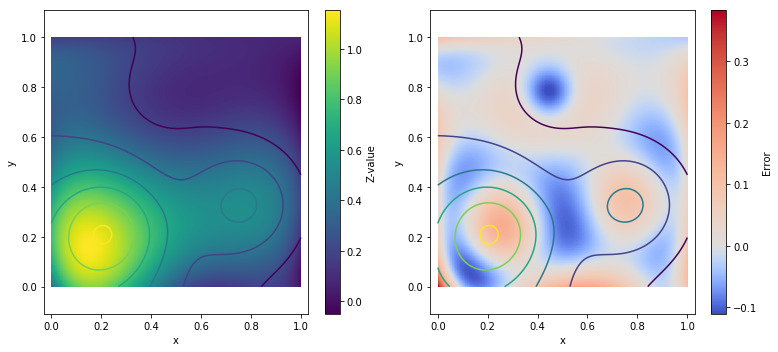

In [5]:
fig = plotting.contour_plot(regr)

In [6]:
z_gt = FrankeFunction(x,y)
zerr = (zhat-z_gt)**2

In [7]:
X = regr._X
var = np.diag(((X.dot(regr.betaVar)) @ X.T))

bias = np.sqrt(np.average(zerr) - np.average(var) - np.average(noise)**2)
bias

0.042019198110444848

# K-fold validation
Generate data for many N, do (N-10)-fold validation and calc avg $\pm$ std in error for in-sample and out-of-sample

N = 196, k = 9
(6, 27)


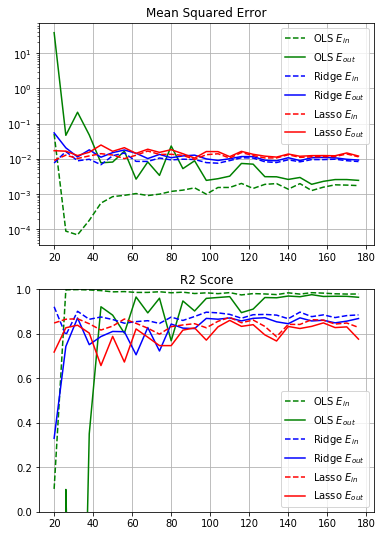

In [8]:
from IPython.display import clear_output

np.random.seed(1)
bins = np.linspace(0,0.01,20)

averages = []
stds = []
N_values = np.arange(40,200,6)
n_test = 20
for N in N_values:
    clear_output(wait = True)
    print('N = {}, k = {}'.format(N, int(N/n_test)))
    x,y,z,noise = tools.generate_data(N)
    ols_out = tools.k_fold_val(x,y,z, k = int(N/n_test), method = 'OLS')
    
    x,y,z,noise = tools.generate_data(N)
    ridge_out = tools.k_fold_val(x,y,z, k = int(N/n_test), lmbd=0.05, method = 'Ridge')
    
    x,y,z,noise = tools.generate_data(N)
    lasso_out = tools.k_fold_val(x,y,z,  k = int(N/n_test), lmbd=0.001, method = 'Lasso')
    
    averages.append([v for v in [*ols_out, *ridge_out, *lasso_out]])
    
averages = np.array(averages).T
r2 = averages[::2]
mse = (averages[1::2])

fig,[ax1,ax2] = plt.subplots(2,1,figsize = [6,9])
print(mse.shape)
N_train = N_values - n_test
ax1.semilogy(N_train, mse[0], '--g', label='OLS $E_{in}$' )
ax1.semilogy(N_train, mse[1], 'g'  , label='OLS $E_{out}$')

ax1.semilogy(N_train, mse[2], '--b', label='Ridge $E_{in}$' )
ax1.semilogy(N_train, mse[3], 'b'  , label='Ridge $E_{out}$')

ax1.semilogy(N_train, mse[4], '--r', label='Lasso $E_{in}$' )
ax1.semilogy(N_train, mse[5], 'r'  , label='Lasso $E_{out}$')


ax2.plot(N_train, r2[0], '--g', label='OLS $E_{in}$' )
ax2.plot(N_train, r2[1], 'g'  , label='OLS $E_{out}$')

ax2.plot(N_train, r2[2], '--b', label='Ridge $E_{in}$' )
ax2.plot(N_train, r2[3], 'b'  , label='Ridge $E_{out}$')

ax2.plot(N_train, r2[4], '--r', label='Lasso $E_{in}$' )
ax2.plot(N_train, r2[5], 'r'  , label='Lasso $E_{out}$')

ax1.grid() 
ax1.legend()
ax2.grid() 
ax2.legend()
ax1.set_title('Mean Squared Error')
ax2.set_title('R2 Score')

# ax1.set_ylim([-0.001,0.05])
ax2.set_ylim([-0.001,1])
fig.savefig('error_over_N.pdf')

Do the same again, but with $M = 10$ random-generated training sets for each $N$.

(88, 3)


(-0.001, 1)

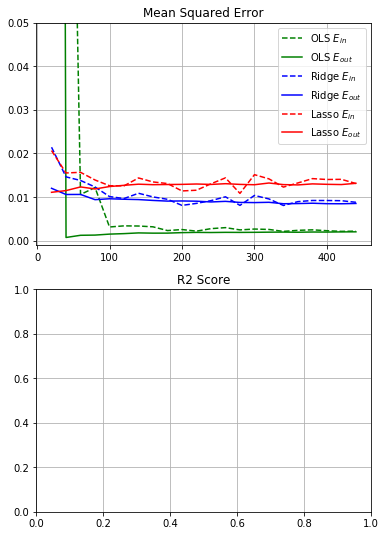

In [124]:
from IPython.display import clear_output
from sklearn.linear_model import Lasso

bins = np.linspace(0,0.01,20)

averages = []
stds = []
N_values = np.arange(40,480,20)
n_test = 20
n_rep = 40

mse_avg = {k:[] for k in ['ols_out','ridge_out','lasso_out',
                           'ols_in','ridge_in','lasso_in']}

for N in N_values:
    clear_output(wait = True)
    mse_temp = {k:[] for k in ['ols_out','ridge_out','lasso_out',
                               'ols_in','ridge_in','lasso_in']}
    for k in range(n_rep):
        x,y,z,noise = tools.generate_data(N)
        x_test = x[:n_test]
        y_test = y[:n_test]
        z_test = z[:n_test]
        x_train = x[n_test:]
        y_train = y[n_test:]
        z_train = z[n_test:]

        design_train = get_X_poly2D(x_train, y_train, deg =5)
        design_test = get_X_poly2D(x_test, y_test, deg =5)

        ols = tools.Regression(design_train,z_train, lmbd = 0.0)
        ridge = tools.Regression(design_train,z_train, lmbd = 0.05)
        lasso = Lasso(alpha = 0.001, fit_intercept = False)
        lasso.fit(design_train, z_train)

        mse_temp['ols_out'].append(tools.squared_error(ols.predict(design_train), z_train))
        mse_temp['ridge_out'].append(tools.squared_error(ridge.predict(design_train), z_train))
        mse_temp['lasso_out'].append(tools.squared_error(lasso.predict(design_train), z_train))
        
        mse_temp['ols_in'].append(tools.squared_error(ols.predict(design_test), z_test))
        mse_temp['ridge_in'].append(tools.squared_error(ridge.predict(design_test), z_test))
        mse_temp['lasso_in'].append(tools.squared_error(lasso.predict(design_test), z_test))
    
    for k, values in mse_temp.items():
        mse_avg[k].append(np.average(values))

fig,[ax1,ax2] = plt.subplots(2,1,figsize = [6,9])
print(mse.shape)
N_train = N_values - n_test
ax1.plot(N_train, mse_avg['ols_in'], '--g', label='OLS $E_{in}$' )
ax1.plot(N_train, mse_avg['ols_out'], 'g'  , label='OLS $E_{out}$')

ax1.plot(N_train, mse_avg['ridge_in'], '--b', label='Ridge $E_{in}$' )
ax1.plot(N_train, mse_avg['ridge_out'], 'b'  , label='Ridge $E_{out}$')

ax1.plot(N_train, mse_avg['lasso_in'], '--r', label='Lasso $E_{in}$' )
ax1.plot(N_train, mse_avg['lasso_out'], 'r'  , label='Lasso $E_{out}$')


# ax2.plot(N_train, r2_in[0], '--g', label='OLS $E_{in}$' )
# ax2.plot(N_train, r2_out[0], 'g'  , label='OLS $E_{out}$')

# ax2.plot(N_train, r2_in[1], '--b', label='Ridge $E_{in}$' )
# ax2.plot(N_train, r2_out[1], 'b'  , label='Ridge $E_{out}$')

# ax2.plot(N_train, r2_in[2], '--r', label='Lasso $E_{in}$' )
# ax2.plot(N_train, r2_out[2], 'r'  , label='Lasso $E_{out}$')

ax1.grid() 
ax1.legend()
ax2.grid() 
ax2.legend()
ax1.set_title('Mean Squared Error')
ax2.set_title('R2 Score')

ax1.set_ylim([-0.001,0.05])
ax2.set_ylim([-0.001,1])

# Test Lasso

/home/halvard/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


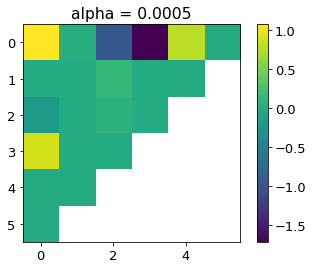

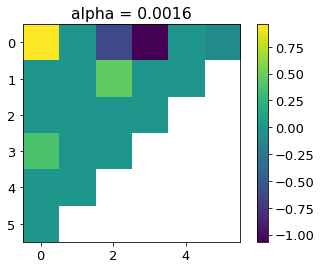

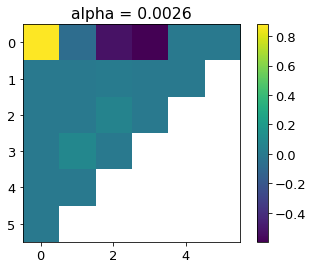

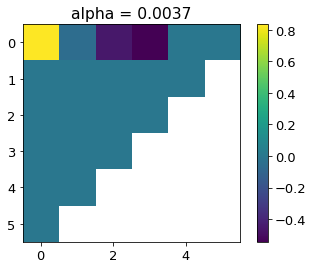

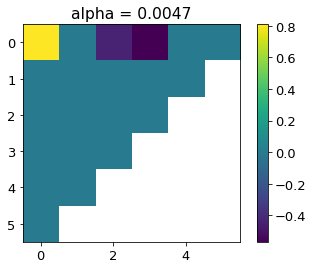

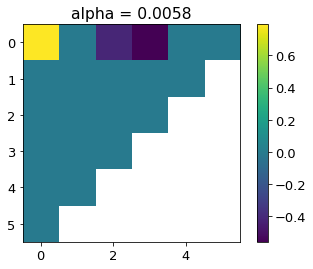

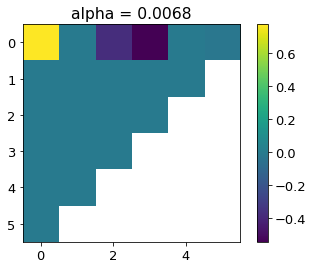

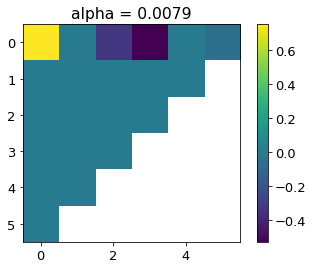

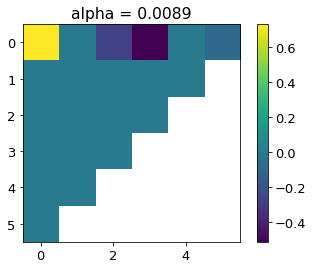

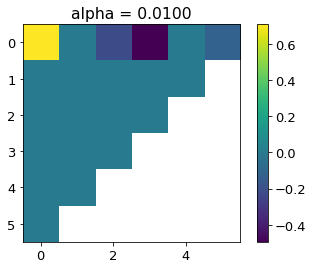

In [539]:
from plotting import contour_plot
from sklearn.linear_model import Lasso

X = get_X_poly2D(x, y, deg = deg)
z_gt = FrankeFunction(x,y)

for alpha in np.linspace(0.0005, 0.010, 10):
    regr = Lasso( alpha = alpha ,fit_intercept = False)
    regr.fit(X, z)

    beta = regr.coef_
    
    zhat = regr.predict(X)
    
    df_exps = tools.get_exp_coeffs(beta, deg = 5, print_beta=False)
    plt.figure()
    plt.title('alpha = {:.4f}'.format(alpha))
    m = plt.imshow(df_exps)
    plt.colorbar(m)
#     fig = contour_plot(regr, plot_err = True)
#     print('total feil: {}'.format(np.sum(np.abs(zhat - z_gt))))
#     fig.suptitle('alpha = {:.4f}'.format(alpha))

In [505]:
symX = X.T @ X
N = symX.shape[0]
lmbd = 0.1

from scipy import linalg
beta = linalg.inv(symX + lmbd*np.eye(N)) @ X.T @ z

beta

array([ 1.04948433,  0.31587174, -0.59975137, -2.37211183,  1.06348865,
       -1.30871314, -0.31673332, -0.53403607,  0.7794553 ,  0.66725102,
        0.92394962, -0.22067446, -0.15441648,  0.49624127,  0.74632533,
        0.80436718,  0.07710595, -0.13821876, -0.19922415, -0.35494877,
       -0.60611638])

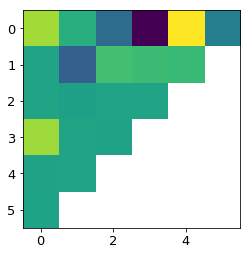

In [534]:
df_exps = tools.get_exp_coeffs(beta, deg = 5, print_beta = False)
plt.imshow(df_exps)

      c:  1.08
    y^1:  0.18
    y^2: -0.90
    y^3: -2.28
    y^4:  1.63
    y^5: -0.59
x^1 y^1: -1.08
x^1 y^2:  0.46
x^1 y^3:  0.39
x^1 y^4:  0.37
   x^2 : -0.00
x^2 y^1: -0.06
   x^3 :  1.05
x^3 y^2: -0.02
   x^4 : -0.03
   x^5 : -0.02


/home/halvard/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


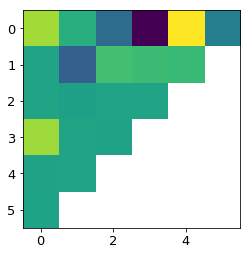

In [529]:
plt.imshow(df_exps)